## Cancer Genomics Assignment 2

In [1]:
import pandas as pd
import numpy as np
import sklearn.pipeline
import sklearn.model_selection
import sklearn.linear_model
import sklearn.ensemble
import sklearn.decomposition 
import sklearn.preprocessing 
import sklearn.tree
import sklearn.compose
import sklearn.metrics
import matplotlib.pyplot as plt
import matplotlib
import sklearn.pipeline
import lzma 
import pickle

matplotlib.rcParams['figure.figsize'] = (12, 10)

Choose a random seed for all further calculations with randomisation.

In [2]:
rs = 22

### Data loading
Load the data using **pandas**, setting the delimiter to '\t' (Tab). Index the rows of the `DataFrame` by the ids for further reference. Drop columns `id` and `chr_start_end`.

In [3]:
data = pd.read_csv('deletion.tsv.gz', delimiter='\t')
data.index = data['id']
data_cleared = data.drop(['id', 'chr_start_end'], axis=1)
data_cleared

,size,vac,vaf,pass,missingrate,precise,ci,ce,refgq,altgq,rdratio,refratio,altratio,maxaltratio,status
id,,,,,,,,,,,,,,,
DEL00000012,808,1,0.000200,0,0.001997,0,287,0.00000,26,11,0.945455,0.0,0.285714,0.285714,NaN
DEL00000018,58,7,0.001399,1,0.000799,1,6,1.90770,21,28,0.648186,0.0,0.500000,0.888889,NaN
DEL00000020,55,1,0.000200,1,0.000000,1,2,1.92127,96,10000,0.668154,0.0,0.547619,0.547619,NaN
DEL00000080,634,10,0.001997,1,0.000000,1,5,1.92573,102,10000,0.434565,0.0,0.545455,1.000000,NaN
DEL00000114,53,307,0.061302,1,0.000000,1,24,1.87118,78,10000,0.717275,0.0,0.590909,1.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DEL00202501,875,10,0.001997,1,0.000000,0,136,0.00000,54,21,0.964944,0.0,0.090909,1.000000,NaN
DEL00202508,336,2,0.000399,1,0.000000,1,5,1.88236,48,10000,0.522206,0.0,0.636364,0.636364,NaN
DEL00202560,898,1,0.000200,1,0.000000,1,5,1.90604,54,135,0.499575,0.0,0.291667,0.291667,NaN


### PCA
To visualise the data PCA is used. 2 separate categories can be seen, however, it is not divided into false and true deletions, as there is a mix of both groups in each of the clusters. Clusters may be another variable, which is divided into two groups.

Explained variance by 2 components: 98.52%.


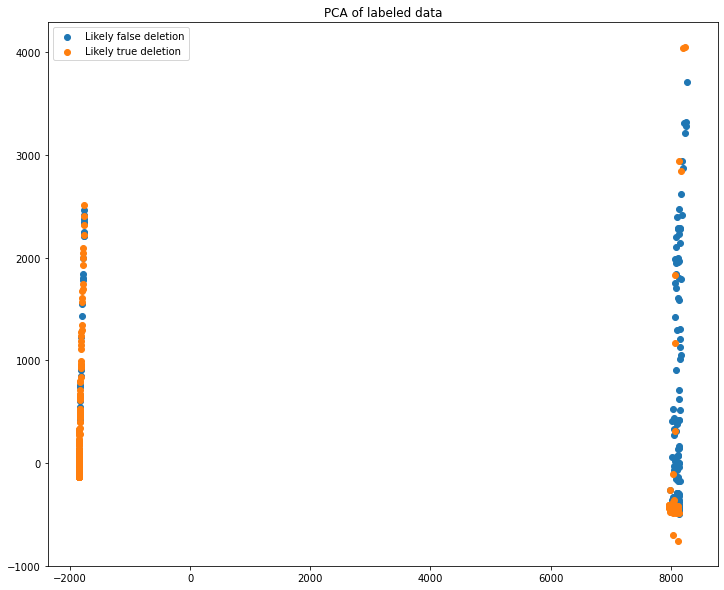

In [7]:
pca = sklearn.decomposition.PCA(n_components=2)
pca_values = pca.fit_transform(data_cleared.drop(['status'], axis=1))

labels = ['Likely false deletion', 'Likely true deletion']

for c in [0, 1]:
    plt.scatter(pca_values[data_cleared["status"]==c][:,0], pca_values[data_cleared["status"]==c][:,1], label=labels[c])

plt.title("PCA of labeled data")
plt.legend()
print(f"Explained variance by 2 components: {100*pca.explained_variance_ratio_[:2].sum():.2f}%.")
plt.show()

### Data preparation
Preparation of data - creating the unlabeled dataset (to be predicted later) and the training and testing dataset, with the ground truth labels stored in `y` and the features in `X`. To create a train/test split sklearn is used.

In [8]:
X = data_cleared[np.logical_not(data_cleared['status'].isna())]
y = X['status'].astype(np.uint8)
X = X.drop(['status'], axis=1)
unlabeled = data_cleared[data_cleared['status'].isna()].drop(['status'], axis=1)

trn_X, tst_X, trn_y, tst_y = sklearn.model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=rs)

The number of likely false and true deletions in the train/test split.

In [9]:
div = pd.DataFrame({'Likely false deletion':[sum(trn_y == 0), sum(tst_y == 0)], 'Likely true deletion':[sum(trn_y == 1), sum(tst_y == 1)], 'Sum':[len(trn_y), len(tst_y)]})
div.index = ['Train', 'Test']
div

,Likely false deletion,Likely true deletion,Sum
Train,201,950,1151
Test,50,238,288


### Model development
Method to find the best parameters for AdaBoostClassifier using sklearn. GridSearchCV is used to try all tried parameters in variable `parameters`, as well as StratifiedKFold for cross-validation.

In [10]:
ada = sklearn.ensemble.AdaBoostClassifier(base_estimator=sklearn.tree.DecisionTreeClassifier(), random_state=rs)

parameters = {'base_estimator__max_depth':[i for i in range(6,16,2)],
              'base_estimator__min_samples_leaf':[3,5,10],
              'n_estimators':[10,15, 50],
              'learning_rate':[0.06, 0.1]}

cv = sklearn.model_selection.StratifiedKFold(5, shuffle=True, random_state=rs)
grid_ada = sklearn.model_selection.GridSearchCV(ada, param_grid=parameters, n_jobs=8, verbose=0)
grid_ada.fit(X=trn_X, y=trn_y)

print(f'Accuracy on train data: {100*grid_ada.score(trn_X, trn_y)}%')
print(f'Accuracy on test data: {100*grid_ada.score(tst_X, tst_y):.2f}%')

Accuracy on train data: 100.0%
Accuracy on test data: 96.88%


Confusion matrix and classification report of precision, recall and F1-score is shown.

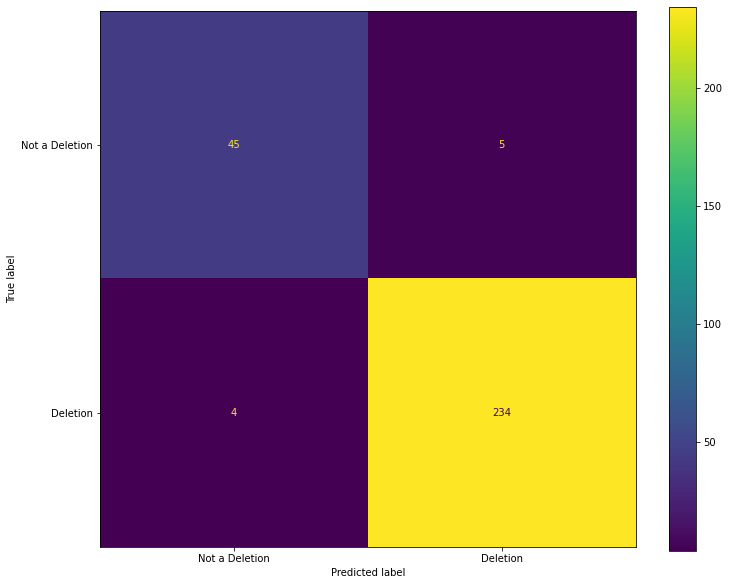

In [11]:
pred_y =  grid_ada.predict(tst_X)
labels = ['Not a Deletion', 'Deletion']
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(tst_y, pred_y), display_labels=labels).plot()

In [12]:
report = pd.DataFrame(sklearn.metrics.classification_report(tst_y, pred_y, target_names=labels, output_dict=True))
report.loc[['precision', 'recall', 'f1-score']]

,Not a Deletion,Deletion,accuracy,macro avg,weighted avg
precision,0.918367,0.979079,0.96875,0.948723,0.968539
recall,0.900000,0.983193,0.96875,0.941597,0.968750
f1-score,0.909091,0.981132,0.96875,0.945111,0.968625


Best of the tried models is saved into the variable best_model and the parameters of the best classifier are written. We can see that overfitting is happening (as the test accuracy is lower than training accuracy, which is 100% correct) - the reason for this may be the size of the dataset (it is too small, thus easy to overfit with high enough capacity of a model). 

In [13]:
best_model = grid_ada.best_estimator_
print(f'Parameters of the best performin model:\n {grid_ada.best_params_}')

Parameters of the best performin model:
 {'base_estimator__max_depth': 12, 'base_estimator__min_samples_leaf': 10, 'learning_rate': 0.1, 'n_estimators': 10}


### Predicting on unlabeled data
The model is used for prediction on the unlabeled data, those predictions are then added to the `DataFrame` and are written to a `predictions_ada.tsv` file.

In [14]:
predictions = best_model.predict(unlabeled)
unlabeled['status'] = predictions
unlabeled.to_csv('./predictions_ada.tsv', sep='\t')

Model can be saved for later use.

In [15]:
with lzma.open("./ada_model.pickle", "wb") as model_file:
    pickle.dump(best_model, model_file)